In [1]:
import numpy as np
import torch
import torch.nn as nn
from collections import Counter
from itertools import chain
import torch.optim as optim
import os
import random
random.seed(42)

In [2]:
# Step 1: Load GloVe Embeddings
def load_glove_embeddings(file_path, embedding_dim):
    """
    Load GloVe embeddings from the file into a dictionary.
    """
    embedding_dict = {}
    with open(file_path, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]  # The word
            vector = np.array(values[1:], dtype="float32")  # The embedding vector
            embedding_dict[word] = vector
    print(f"Loaded {len(embedding_dict)} word vectors.")
    return embedding_dict


In [3]:
# Tokenize comments
def tokenize_comments(comments, vocab):
    tokenized_comments = []
    for comment in comments:
        tokens = comment.split()  # Simple whitespace tokenizer
        token_indices = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
        tokenized_comments.append(token_indices)
    return tokenized_comments

# Pad sequences to a fixed length
def pad_sequences(sequences, max_len, pad_value):
    padded_sequences = []
    for seq in sequences:
        if len(seq) < max_len:
            seq = seq + [pad_value] * (max_len - len(seq))
        else:
            seq = seq[:max_len]
        padded_sequences.append(seq)
    return padded_sequences

In [4]:
# Step 3: Create the Embedding Matrix
def create_embedding_matrix(vocab, glove_embeddings, embedding_dim):
    """
    Create an embedding matrix where each row corresponds to a token in the vocabulary.
    """
    vocab_size = len(vocab)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))  # Initialize matrix with zeros

    for word, idx in vocab.items():
        if word in glove_embeddings:
            embedding_matrix[idx] = glove_embeddings[word]
        else:
            # Initialize randomly for missing words
            embedding_matrix[idx] = np.random.uniform(-0.01, 0.01, embedding_dim)

    return embedding_matrix

In [5]:
# Path to GloVe file and embedding dimensions
glove_file_path = "glove.6B.100d.txt"
embedding_dim = 100

In [6]:
# Load GloVe embeddings
glove_embeddings = load_glove_embeddings(glove_file_path, embedding_dim)


Loaded 400001 word vectors.


In [7]:
# Step 2: Build Vocabulary
# Example tokenized dataset (replace with your dataset tokens)
vocab_file = 'imdb.vocab'
with open(vocab_file, 'r') as f:
    vocab_words = f.read().splitlines()

tokenized_sentences = vocab_words
tokenized_sentences.append('<UNK>')  # Add <UNK> token for unknown words
tokenized_sentences.append('<PAD>')  # Add <PAD> token to pad sequences
# Create vocabulary
vocab_size = len(vocab_words)
# tokens = list(chain(*tokenized_sentences))
vocab_counter = Counter(tokenized_sentences)


In [8]:
# Assign an index to each word in the vocabulary
vocab = {word: idx for idx, (word, _) in enumerate(vocab_counter.most_common())}
print(f"Vocabulary size: {len(vocab)}")


Vocabulary size: 89529


In [9]:
# Create embedding matrix
embedding_matrix = create_embedding_matrix(vocab, glove_embeddings, embedding_dim)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (89529, 100)


In [10]:
# Step 4: Load Embedding Matrix into PyTorch Embedding Layer
embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float32)

# Define the embedding layer
embedding_layer = nn.Embedding(len(vocab), embedding_dim)
embedding_layer.weight.data.copy_(embedding_tensor)  # Load pre-trained weights

tensor([[-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        [-0.0720,  0.2313,  0.0237,  ..., -0.7189,  0.8689,  0.1954],
        [-0.2709,  0.0440, -0.0203,  ..., -0.4923,  0.6369,  0.2364],
        ...,
        [ 0.0094, -0.0090,  0.0041,  ...,  0.0084,  0.0062, -0.0027],
        [-0.0064,  0.0066,  0.0024,  ..., -0.0091, -0.0033, -0.0092],
        [ 0.0093,  0.0039, -0.0020,  ..., -0.0076,  0.0030, -0.0046]])

In [11]:
# Optionally freeze the embedding layer
embedding_layer.weight.requires_grad = False
print("Embedding layer is ready.")

# Step 5: Test the Embedding Layer
example_sentence = ["this", "movie", "is", "great"]  # Example input sentence
token_indices = [vocab.get(token, vocab["<UNK>"]) for token in example_sentence]


Embedding layer is ready.


In [12]:
# Convert token indices to a PyTorch tensor
input_tensor = torch.tensor(token_indices).unsqueeze(0)  # Add batch dimension

# Pass through the embedding layer
output_embeddings = embedding_layer(input_tensor)
print(f"Input indices: {token_indices}")
print(f"Output embeddings shape: {output_embeddings.shape}")


Input indices: [9, 15, 5, 83]
Output embeddings shape: torch.Size([1, 4, 100])


In [13]:


# Output embedding for visualization
print("Output embeddings for the example sentence:")
print(output_embeddings.shape)


Output embeddings for the example sentence:
torch.Size([1, 4, 100])


In [14]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=2, embedding_matrix=None, freeze_embeddings=True):
        super(SentimentLSTM, self).__init__()

        # Step 1. Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.tensor(embedding_matrix, dtype=torch.float32))
            self.embedding.weight.requires_grad = not freeze_embeddings
        
        # Step 2. LSTM Layer with Multiple Layers
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=0.2)
        
        # Step 3. Fully Connected Layers (Stacked for Depth)
        self.fc1 = nn.Linear(hidden_dim, 100)
        self.fc2 = nn.Linear(100, output_dim)
        
        # Step 4. Activation Functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Pass input through embedding layer
        embedded = self.embedding(x)
        
        # Pass embeddings through the LSTM layer
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # Take the output from the last hidden state
        hidden_state = hidden[-1]
        
        # Pass through fully connected layers
        fc1_out = self.relu(self.fc1(hidden_state))
        final_output = self.sigmoid(self.fc2(fc1_out))
        
        return final_output


In [15]:
class SentimentGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=2, embedding_matrix=None, freeze_embeddings=True):
        super(SentimentGRU, self).__init__()
        
        # Step 1. Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.tensor(embedding_matrix, dtype=torch.float32))
            self.embedding.weight.requires_grad = not freeze_embeddings
        
        # Step 2. GRU Layer with Multiple Layers
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        
        # Step 3. Fully Connected Layers (Stacked for Depth)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)
        
        # Step 4. Activation Functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Pass input through embedding layer
        embedded = self.embedding(x)
        
        # Pass embeddings through the GRU layer
        gru_out, hidden = self.gru(embedded)
        
        # Take the output from the last hidden state
        hidden_state = hidden[-1]
        
        # Pass through fully connected layers
        fc1_out = self.relu(self.fc1(hidden_state))
        final_output = self.sigmoid(self.fc2(fc1_out))
        
        return final_output


In [16]:
vocab_size = len(vocab)
embedding_dim = 100  # Same as GloVe
hidden_dim = 128
output_dim = 1
learning_rate = 0.001
num_epochs = 28 # Number of epochs
NUM_LAYERS = 2
# Initialize the LSTM model
model = SentimentLSTM(vocab_size, embedding_dim, hidden_dim, output_dim,NUM_LAYERS ,embedding_matrix, freeze_embeddings=True, )
model_gru = SentimentGRU(vocab_size, embedding_dim, hidden_dim, output_dim, NUM_LAYERS, embedding_matrix, freeze_embeddings=True)
# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [17]:

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
criterion_gru = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer_gru = optim.Adam(model_gru.parameters(), lr=learning_rate)

In [18]:
batched_comments = []
pos = os.listdir('train/pos')
neg = os.listdir('train/neg')
pos = list(filter(lambda x: '._' not in x, pos))
neg = list(filter(lambda x: '._' not in x, neg))


In [19]:
# Read the comments from files
pos_comments = [open(f'train/pos/{f}', 'r').read() for f in pos]
neg_comments = [open(f'train/neg/{f}', 'r').read() for f in neg]

# Label the comments
pos_labels = [1] * len(pos_comments)
neg_labels = [0] * len(neg_comments)

# Combine and shuffle the comments and labels
comments = pos_comments + neg_comments
labels = pos_labels + neg_labels

In [20]:
combined = list(zip(comments, labels))
random.shuffle(combined)
comments, labels = zip(*combined)

In [21]:
# Create batches of size 50
batch_size = 50
batched_comments = [(comments[i:i + batch_size], labels[i:i + batch_size]) for i in range(0, len(comments), batch_size)]
len(batched_comments)

750

In [22]:
train_size = 0.8
test_size = 0.2
train_len = train_size * len(batched_comments)
test_len = len(batched_comments) - train_len
train_comments = batched_comments[:int(train_len)]
val_comments = labels[:int(train_len)]

test_comments = batched_comments[int(train_len):]
test_labels = labels[int(train_len):]

In [23]:
losses = []
losses_gru = []
accuracies = []
accuracies_gru = []

In [24]:
# Training Loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0
    epoch_loss_gru = 0
    correct_predictions = 0
    correct_predictions_gru = 0
    total_predictions = 0
    total_predictions_gru = 0

    # Loop through batches
    for comments, labels in train_comments:  # Assuming train_comments is a list of (comments, labels) batches
        # Move data to device
        comments_padded = pad_sequences(tokenize_comments(comments, vocab), max_len=200, pad_value=vocab["<PAD>"])
        
        comments = torch.tensor(comments_padded, dtype=torch.long).to(device)  # Shape: [batch_size, sequence_length]
        labels = torch.tensor(labels, dtype=torch.float32).to(device)  # Shape: [batch_size]

        # Forward pass
        predictions = model(comments).squeeze(1)  # Shape: [batch_size]
        predictions_gru = model_gru(comments).squeeze(1)

        # Compute loss
        loss = criterion(predictions, labels)
        loss_gru = criterion_gru(predictions_gru, labels)
        # Backward pass
        optimizer.zero_grad()  # Reset gradients
        optimizer_gru.zero_grad()
        loss.backward()  # Backpropagation
        loss_gru.backward()
        optimizer.step()  # Update model weights
        optimizer_gru.step() # Update model weights

        # Accumulate loss and accuracy
        epoch_loss += loss.item()
        epoch_loss_gru += loss_gru.item()
        preds = (predictions >= 0.5).float()  # Convert probabilities to binary labels
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)
        preds_gru = (predictions_gru >= 0.5).float()
        correct_predictions_gru += (preds_gru == labels).sum().item()
        total_predictions_gru += labels.size(0)


    # Print epoch summary
    accuracy = correct_predictions / total_predictions
    accuracy_gru = correct_predictions_gru / total_predictions_gru
    losses.append(epoch_loss / len(train_comments))
    losses_gru.append(epoch_loss_gru / len(train_comments))
    accuracies.append(accuracy)
    accuracies_gru.append(accuracy_gru)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_comments):.4f}, Accuracy: {accuracy:.4f}")
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss_gru / len(train_comments):.4f}, Accuracy: {accuracy_gru:.4f}")

Epoch 1/28, Loss: 0.6918, Accuracy: 0.5091
Epoch 1/28, Loss: 0.6893, Accuracy: 0.5235
Epoch 2/28, Loss: 0.6933, Accuracy: 0.5001
Epoch 2/28, Loss: 0.6918, Accuracy: 0.5125
Epoch 3/28, Loss: 0.6930, Accuracy: 0.5029
Epoch 3/28, Loss: 0.6932, Accuracy: 0.5032
Epoch 4/28, Loss: 0.6930, Accuracy: 0.5079
Epoch 4/28, Loss: 0.6932, Accuracy: 0.4971
Epoch 5/28, Loss: 0.6931, Accuracy: 0.4981
Epoch 5/28, Loss: 0.6932, Accuracy: 0.4969
Epoch 6/28, Loss: 0.6779, Accuracy: 0.5529
Epoch 6/28, Loss: 0.6932, Accuracy: 0.4961
Epoch 7/28, Loss: 0.4889, Accuracy: 0.7712
Epoch 7/28, Loss: 0.6932, Accuracy: 0.4964
Epoch 8/28, Loss: 0.4279, Accuracy: 0.8053
Epoch 8/28, Loss: 0.6932, Accuracy: 0.4964
Epoch 9/28, Loss: 0.4022, Accuracy: 0.8191
Epoch 9/28, Loss: 0.6932, Accuracy: 0.4964
Epoch 10/28, Loss: 0.3809, Accuracy: 0.8310
Epoch 10/28, Loss: 0.6932, Accuracy: 0.4960
Epoch 11/28, Loss: 0.3603, Accuracy: 0.8428
Epoch 11/28, Loss: 0.6932, Accuracy: 0.4964
Epoch 12/28, Loss: 0.3439, Accuracy: 0.8512
Epoch 

In [25]:
def test_model(model, test_comments, test_labels, batch_size=32):
    model.eval()  # Set model to evaluation mode
    
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Disable gradient calculations
        for comment_obj in test_comments:
            # Extract batch
            comments_batch = comment_obj[0]
            labels_batch = comment_obj[1]
            comments_padded = pad_sequences(tokenize_comments(comments_batch, vocab), max_len=200, pad_value=vocab["<PAD>"])

            # Convert to tensors and move to device
            comments = torch.tensor(comments_padded, dtype=torch.long).to(device)
            labels = torch.tensor(labels_batch, dtype=torch.float32).to(device)

            # Forward pass
            predictions = model(comments).squeeze(1)

            # Compute loss
            loss = criterion(predictions, labels)
            total_loss += loss.item()

            # Accuracy calculations
            preds = (predictions >= 0.5).float()
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

    # Compute metrics
    average_loss = total_loss / (len(test_comments) // batch_size)
    accuracy = correct_predictions / total_predictions

    print(f"Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return average_loss, accuracy

# Call the test function
test_model(model, test_comments, test_labels)
test_model(model_gru, test_comments, test_labels)

Test Loss: 23.3621, Test Accuracy: 0.8211
Test Loss: 25.9931, Test Accuracy: 0.4992


(25.993108212947845, 0.4992)

In [26]:
import matplotlib.pyplot as plt

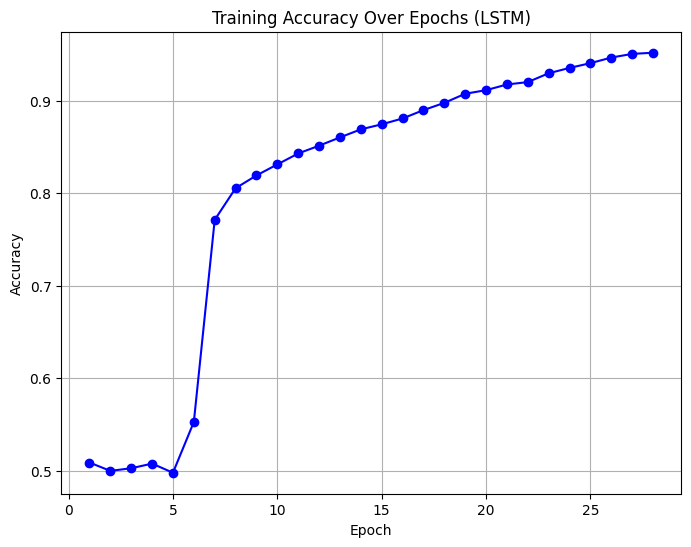

In [27]:
# Plot Accuracy vs. Epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', linestyle='-', color='b')
plt.title('Training Accuracy Over Epochs (LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

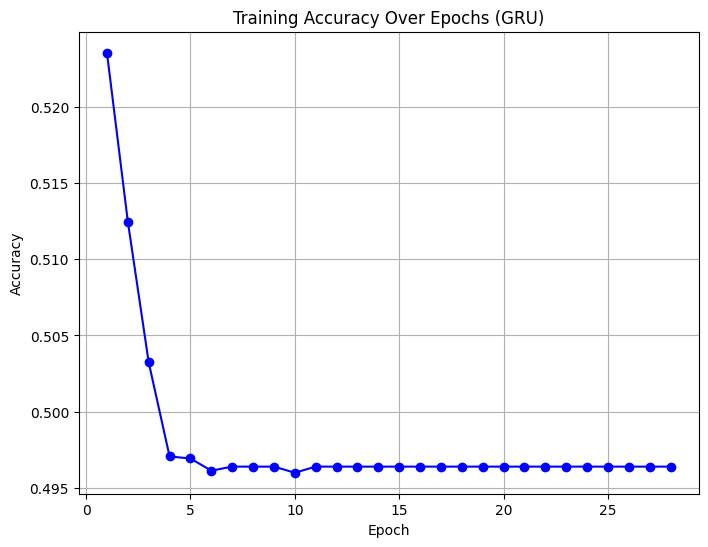

In [28]:
# Plot Accuracy vs. Epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(accuracies_gru) + 1), accuracies_gru, marker='o', linestyle='-', color='b')
plt.title('Training Accuracy Over Epochs (GRU)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

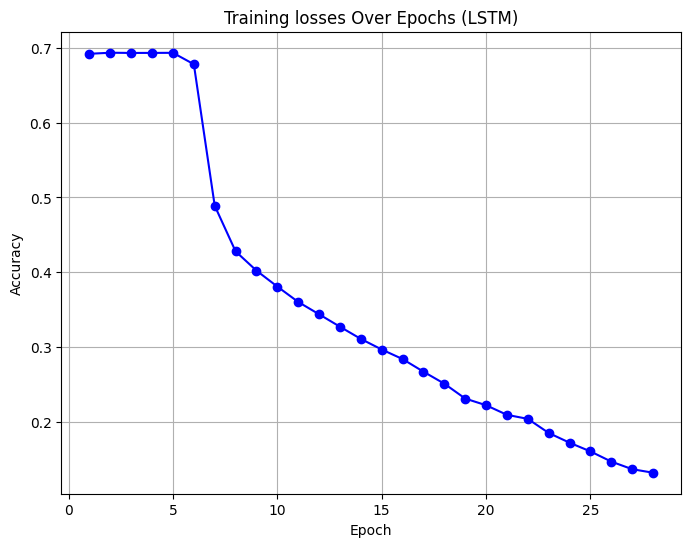

In [29]:
# Plot Accuracy vs. Epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='b')
plt.title('Training losses Over Epochs (LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

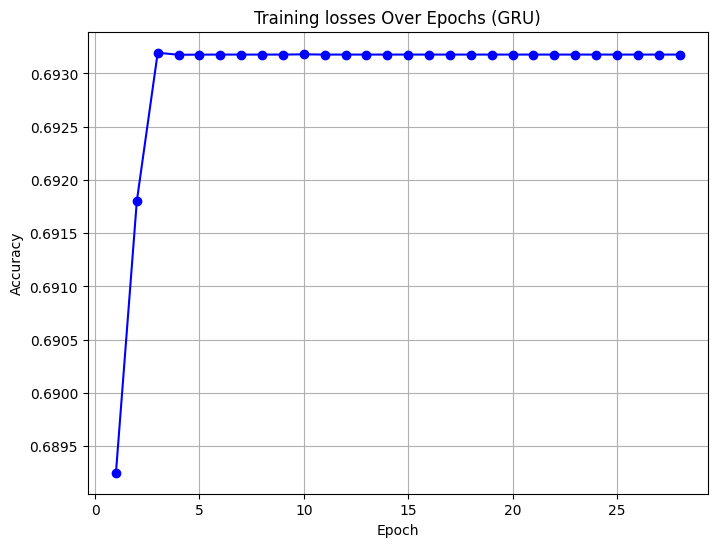

In [30]:
# Plot Accuracy vs. Epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(losses_gru) + 1), losses_gru, marker='o', linestyle='-', color='b')
plt.title('Training losses Over Epochs (GRU)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [31]:

comments_padded = pad_sequences(tokenize_comments(test_comments[0][0], vocab), max_len=200, pad_value=vocab["<PAD>"])


In [32]:
torch.save(model.state_dict(), "model_parameters_2_LAYERS.pth")
torch.save(model_gru.state_dict(), "model_parameters_gru_2_LAYERS.pth")
